In [42]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from datetime import datetime

In [27]:
# connexion a la base de donnees
conn = sqlite3.connect('../Datas/db/fraude_detection_warehouse_.db')

In [28]:
# Extraction des tables
alert = pd.read_sql_query("SELECT * FROM alerts", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
devices = pd.read_sql_query("SELECT * FROM devices", conn)
transaction_history = pd.read_sql_query("SELECT * FROM transaction_history", conn)
transaction_patterns= pd.read_sql_query("SELECT * FROM transaction_patterns", conn)
transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

alert.head()


,alert_id,transaction_id,alert_date,alert_type,alert_status,description
0,51a83841-582a-49f0-b1b7-534b593f02d8,19a371c6131c4fadaaa4b59555d41927,2022-04-25 03:40:24,large transaction,closed,Woman life might health ever statement range.\...
1,3eb26fef-a1cf-49e2-ba05-23c0c72a4f7f,5462c26c89794e108f33acd5a6aba434,2020-05-08 18:50:52,large transaction,open,Both his benefit especially development wester...
2,b9103754-365e-42c6-a263-3cd296504dcd,8ad7f3906e4d410988894e9983e21cad,2021-09-10 03:36:03,large transaction,closed,Structure night election civil old. White boy ...
3,5df28a26-9f75-40bc-82a2-a2a43da4f3b8,b9504927c22846babb4943e2597f11c9,2022-04-02 08:03:32,suspicious activity,closed,White big create light blood commercial countr...
4,acc68d65-0fea-4541-a7aa-e0982fdfd4fe,1fc48491d2724c8fb2c3d7ab08c339c8,2024-02-22 10:38:47,large transaction,open,Look her cost. Later which black computer.\nLi...


In [29]:
# Fusion des tables
df1 = transactions.merge(customers, on='customer_id', how='left').drop(columns=['first_name', 'last_name', 'transaction_date'])
df2 = df1.merge(devices, on='device_id', how='left')
df3 = df2.merge(transaction_history, on=['customer_id', 'transaction_id'], how='left')

df3.head()

,transaction_id,customer_id,device_id,transaction_type,amount,status,is_fraud,location,email,phone_number,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,depôt,9.385805e+06,réussie,1,Douala,Kim.Nguyen@lopez-wolfe.com,+237 656344405,...,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1e9c3c0fc0b1496d8d2901d0f8f3531d,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,depôt,3.358191e+06,réussie,0,Bafoussam,Gregory.Webb@scott.com,+237 684119567,...,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,d9970217233245029374bceecdc315c0,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,depôt,7.307758e+06,réussie,1,Bafoussam,Mary.Frank@mcbride-oliver.biz,+237 682981090,...,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,76fcc12cfc944467b6465cd0aba2893c,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,transfert,3.127519e+06,réussie,1,Bafoussam,Mark.Nelson@yang.info,+237 681338859,...,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,3bb9c05095104929b845b85e2daa86e8,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,retrait,4.435274e+06,réussie,0,Yaoundé,Deborah.Stokes@faulkner-randall.net,+237 677098362,...,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,64f19595555c42c5ae3d1fb9eb17c793,9.679731e+06,5.244457e+06,2019-12-29


In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transaction_id     100000 non-null  object 
 1   customer_id        100000 non-null  object 
 2   device_id          100000 non-null  object 
 3   transaction_type   100000 non-null  object 
 4   amount             100000 non-null  float64
 5   status             100000 non-null  object 
 6   is_fraud           100000 non-null  int64  
 7   location           100000 non-null  object 
 8   email              100000 non-null  object 
 9   phone_number       100000 non-null  object 
 10  registration_date  100000 non-null  object 
 11  date_of_birth      100000 non-null  object 
 12  address            100000 non-null  object 
 13  city               100000 non-null  object 
 14  region             100000 non-null  object 
 15  device_type        100000 non-null  object 
 16  os 

In [31]:
list(df3.columns)

['transaction_id',
 'customer_id',
 'device_id',
 'transaction_type',
 'amount',
 'status',
 'is_fraud',
 'location',
 'email',
 'phone_number',
 'registration_date',
 'date_of_birth',
 'address',
 'city',
 'region',
 'device_type',
 'os',
 'manufacturer',
 'model',
 'last_used',
 'history_id',
 'previous_balance',
 'new_balance',
 'transaction_date']

In [32]:
date_columns = ["registration_date", "date_of_birth", "transaction_date", "last_used"]

for column in date_columns:
    df3[column] = pd.to_datetime(df3[column])

df3.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     100000 non-null  object        
 1   customer_id        100000 non-null  object        
 2   device_id          100000 non-null  object        
 3   transaction_type   100000 non-null  object        
 4   amount             100000 non-null  float64       
 5   status             100000 non-null  object        
 6   is_fraud           100000 non-null  int64         
 7   location           100000 non-null  object        
 8   email              100000 non-null  object        
 9   phone_number       100000 non-null  object        
 10  registration_date  100000 non-null  datetime64[ns]
 11  date_of_birth      100000 non-null  datetime64[ns]
 12  address            100000 non-null  object        
 13  city               100000 non-null  object   

In [33]:
df3.describe()

,amount,is_fraud,registration_date,date_of_birth,last_used,previous_balance,new_balance,transaction_date
count,1.000000e+05,100000.000000,100000,100000,100000,1.000000e+05,1.000000e+05,100000
mean,5.587385e+06,0.567070,2011-06-27 22:30:43.200000256,1971-07-11 08:37:34.752000008,2022-01-19 14:20:51.415449856,1.057399e+07,1.057244e+07,2020-12-30 17:28:32.159999744
min,1.639254e+02,0.000000,2005-01-01 00:00:00,1948-07-23 00:00:00,2019-07-23 19:08:51,7.688654e+04,9.024776e+00,2018-01-01 00:00:00
25%,2.660834e+06,0.000000,2008-03-21 00:00:00,1959-11-12 00:00:00,2020-10-19 15:29:06.750000128,7.279777e+06,4.493306e+06,2019-07-03 00:00:00
50%,5.309755e+06,1.000000,2011-07-01 00:00:00,1971-08-17 00:00:00,2022-01-20 08:52:56.500000,1.042128e+07,8.351001e+06,2020-12-31 00:00:00
75%,8.046252e+06,1.000000,2014-10-12 00:00:00,1983-04-26 00:00:00,2023-04-17 10:00:49.500000,1.371817e+07,1.563911e+07,2022-07-01 00:00:00
max,1.574056e+07,1.000000,2017-12-31 00:00:00,1994-07-20 00:00:00,2024-07-22 20:15:13,2.505568e+07,4.037580e+07,2024-01-01 00:00:00
std,3.514901e+06,0.495484,NaN,NaN,NaN,4.556663e+06,8.011172e+06,NaN


In [34]:
data = df3.copy()
data.drop(columns=["transaction_id", "customer_id", "device_id", "email", "phone_number", "address", "history_id"], inplace=True)
data.head()

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,os,manufacturer,model,last_used,previous_balance,new_balance,transaction_date
0,depôt,9.385805e+06,réussie,1,Douala,2015-03-02,1981-01-07,Ayos,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1.933918e+07,2.872498e+07,2020-02-12
1,depôt,3.358191e+06,réussie,0,Bafoussam,2008-01-09,1986-12-05,Bafoussam,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,9.557160e+06,1.291535e+07,2022-02-03
2,depôt,7.307758e+06,réussie,1,Bafoussam,2015-06-06,1993-07-13,Bafoussam,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,1.430163e+07,2.160939e+07,2019-11-09
3,transfert,3.127519e+06,réussie,1,Bafoussam,2011-06-27,1977-03-30,Bafoussam,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,7.646344e+06,4.518825e+06,2018-07-18
4,retrait,4.435274e+06,réussie,0,Yaoundé,2006-05-08,1950-09-29,Douala,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,9.679731e+06,5.244457e+06,2019-12-29


In [35]:
# Encodage des variables categorielles
le = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_type   100000 non-null  int32         
 1   amount             100000 non-null  float64       
 2   status             100000 non-null  int32         
 3   is_fraud           100000 non-null  int64         
 4   location           100000 non-null  int32         
 5   registration_date  100000 non-null  datetime64[ns]
 6   date_of_birth      100000 non-null  datetime64[ns]
 7   city               100000 non-null  int32         
 8   region             100000 non-null  int32         
 9   device_type        100000 non-null  int32         
 10  os                 100000 non-null  int32         
 11  manufacturer       100000 non-null  int32         
 12  model              100000 non-null  int32         
 13  last_used          100000 non-null  datetime6

In [37]:
df3.describe()

,amount,is_fraud,registration_date,date_of_birth,last_used,previous_balance,new_balance,transaction_date
count,1.000000e+05,100000.000000,100000,100000,100000,1.000000e+05,1.000000e+05,100000
mean,5.587385e+06,0.567070,2011-06-27 22:30:43.200000256,1971-07-11 08:37:34.752000008,2022-01-19 14:20:51.415449856,1.057399e+07,1.057244e+07,2020-12-30 17:28:32.159999744
min,1.639254e+02,0.000000,2005-01-01 00:00:00,1948-07-23 00:00:00,2019-07-23 19:08:51,7.688654e+04,9.024776e+00,2018-01-01 00:00:00
25%,2.660834e+06,0.000000,2008-03-21 00:00:00,1959-11-12 00:00:00,2020-10-19 15:29:06.750000128,7.279777e+06,4.493306e+06,2019-07-03 00:00:00
50%,5.309755e+06,1.000000,2011-07-01 00:00:00,1971-08-17 00:00:00,2022-01-20 08:52:56.500000,1.042128e+07,8.351001e+06,2020-12-31 00:00:00
75%,8.046252e+06,1.000000,2014-10-12 00:00:00,1983-04-26 00:00:00,2023-04-17 10:00:49.500000,1.371817e+07,1.563911e+07,2022-07-01 00:00:00
max,1.574056e+07,1.000000,2017-12-31 00:00:00,1994-07-20 00:00:00,2024-07-22 20:15:13,2.505568e+07,4.037580e+07,2024-01-01 00:00:00
std,3.514901e+06,0.495484,NaN,NaN,NaN,4.556663e+06,8.011172e+06,NaN


In [38]:
import pandas as pd

# Fonction pour extraire les composantes de date
def extract_date_features(data, column):
    data[f'{column}_day'] = data[column].dt.day
    data[f'{column}_month'] = data[column].dt.month
    data[f'{column}_year'] = data[column].dt.year
    data[f'{column}_weekday'] = data[column].dt.weekday
    data[f'{column}_quarter'] = data[column].dt.quarter
    return data

# Conversion des dates et extraction des caractéristiques
date_columns = ['transaction_date','last_used']
for col in date_columns:
    data = extract_date_features(data, col)
    
    # Suppression de la colonne de date originale
    data = data.drop(columns=[col])

Index(['transaction_id', 'customer_id', 'device_id', 'transaction_type',
       'amount', 'status', 'is_fraud', 'location', 'email', 'phone_number',
       'registration_date', 'date_of_birth', 'address', 'city', 'region',
       'device_type', 'os', 'manufacturer', 'model', 'last_used', 'history_id',
       'previous_balance', 'new_balance', 'transaction_date'],
      dtype='object')


In [39]:
print(data.columns)

Index(['transaction_type', 'amount', 'status', 'is_fraud', 'location',
       'registration_date', 'date_of_birth', 'city', 'region', 'device_type',
       'os', 'manufacturer', 'model', 'previous_balance', 'new_balance',
       'transaction_date_day', 'transaction_date_month',
       'transaction_date_year', 'transaction_date_weekday',
       'transaction_date_quarter', 'last_used_day', 'last_used_month',
       'last_used_year', 'last_used_weekday', 'last_used_quarter'],
      dtype='object')


In [41]:
# Sélectionner uniquement les colonnes de date nouvellement créées
date_columns = [col for col in data.columns if any(x in col for x in ['_day', '_month', '_year', '_weekday', '_quarter'])]

# Afficher les premières lignes de ces colonnes
print(data[date_columns].head(10))

   transaction_date_day  transaction_date_month  transaction_date_year  \
0                    12                       2                   2020   
1                     3                       2                   2022   
2                     9                      11                   2019   
3                    18                       7                   2018   
4                    29                      12                   2019   
5                     4                       1                   2022   
6                     3                       9                   2019   
7                     3                      12                   2023   
8                     2                       2                   2019   
9                     4                       8                   2022   

   transaction_date_weekday  transaction_date_quarter  last_used_day  \
0                         2                         1              1   
1                         3              

In [43]:
date_of_today = datetime.now()

def calcul_date(registration_date, date_of_birth):
    difference_registration = date_of_today - registration_date
    difference_birth = date_of_today - date_of_birth
    return int(difference_registration.days/360), int(difference_birth.days/360)

data[['year_since_registration', 'year_since_birth']] = data.apply(
    lambda row: calcul_date(row['registration_date'], row['date_of_birth']), axis=1, result_type='expand'
)

In [44]:
data.head()

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,...,transaction_date_year,transaction_date_weekday,transaction_date_quarter,last_used_day,last_used_month,last_used_year,last_used_weekday,last_used_quarter,year_since_registration,year_since_birth
0,0,9.385805e+06,0,1,31,2015-03-02,1981-01-07,6,4,1,...,2020,2,1,1,12,2023,4,4,9,44
1,0,3.358191e+06,0,0,11,2008-01-09,1986-12-05,11,16,1,...,2022,3,1,12,9,2020,5,3,16,38
2,0,7.307758e+06,0,1,11,2015-06-06,1993-07-13,11,16,0,...,2019,5,4,5,10,2020,0,4,9,31
3,2,3.127519e+06,0,1,11,2011-06-27,1977-03-30,11,16,1,...,2018,2,3,29,5,2020,4,2,13,48
4,1,4.435274e+06,0,0,98,2006-05-08,1950-09-29,31,12,0,...,2019,6,4,30,4,2021,4,2,18,74


In [59]:
print(df3[date_columns].tail(10))

       transaction_date_x_day  transaction_date_x_month  \
99990                       1                         1   
99991                       1                         1   
99992                       1                         1   
99993                       1                         1   
99994                       1                         1   
99995                       1                         1   
99996                       1                         1   
99997                       1                         1   
99998                       1                         1   
99999                       1                         1   

       transaction_date_x_year  transaction_date_x_weekday  \
99990                     1970                           3   
99991                     1970                           3   
99992                     1970                           3   
99993                     1970                           3   
99994                     1970          

In [61]:
# Afficher un résumé statistique de ces colonnes
print(df3[date_columns].describe())

       transaction_date_x_day  transaction_date_x_month  \
count                100000.0                  100000.0   
mean                      1.0                       1.0   
std                       0.0                       0.0   
min                       1.0                       1.0   
25%                       1.0                       1.0   
50%                       1.0                       1.0   
75%                       1.0                       1.0   
max                       1.0                       1.0   

       transaction_date_x_year  transaction_date_x_weekday  \
count                 100000.0                    100000.0   
mean                    1970.0                         3.0   
std                        0.0                         0.0   
min                     1970.0                         3.0   
25%                     1970.0                         3.0   
50%                     1970.0                         3.0   
75%                     1970.0    

In [62]:
# Afficher les types de données de ces colonnes
print(df3[date_columns].dtypes)

transaction_date_x_day        int32
transaction_date_x_month      int32
transaction_date_x_year       int32
transaction_date_x_weekday    int32
transaction_date_x_quarter    int32
registration_date_day         int32
registration_date_month       int32
registration_date_year        int32
registration_date_weekday     int32
registration_date_quarter     int32
date_of_birth_day             int32
date_of_birth_month           int32
date_of_birth_year            int32
date_of_birth_weekday         int32
date_of_birth_quarter         int32
dtype: object
transaction_date_x_day        1
transaction_date_x_month      1
transaction_date_x_year       1
transaction_date_x_weekday    1
transaction_date_x_quarter    1
registration_date_day         1
registration_date_month       1
registration_date_year        1
registration_date_weekday     1
registration_date_quarter     1
date_of_birth_day             1
date_of_birth_month           1
date_of_birth_year            1
date_of_birth_weekday         

In [63]:
# Afficher le nombre de valeurs uniques pour chaque colonne
print(df3[date_columns].nunique())

transaction_date_x_day        1
transaction_date_x_month      1
transaction_date_x_year       1
transaction_date_x_weekday    1
transaction_date_x_quarter    1
registration_date_day         1
registration_date_month       1
registration_date_year        1
registration_date_weekday     1
registration_date_quarter     1
date_of_birth_day             1
date_of_birth_month           1
date_of_birth_year            1
date_of_birth_weekday         1
date_of_birth_quarter         1
dtype: int64


In [64]:
lignes_avec_manquantes = df3[df3.isnull().any(axis=1)]

nombre_lignes_manquantes = lignes_avec_manquantes.shape[0]

print("Nombre de lignes avec des valeurs manquantes :", nombre_lignes_manquantes)

Nombre de lignes avec des valeurs manquantes : 0


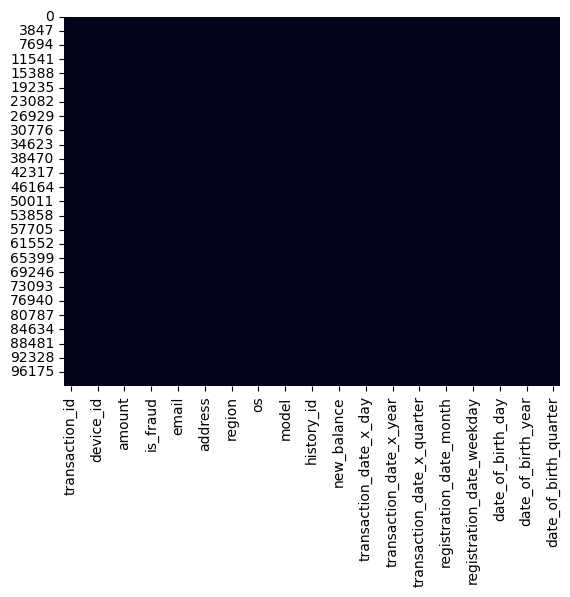

In [65]:
# Visualiser les valeurs manquantes dans un DataFrame 
sns.heatmap(df3.isnull(), cbar=False)
plt.show()

In [ ]:
# Gestion des valeurs manquantes
# df3 = df3.fillna(df3.mean())

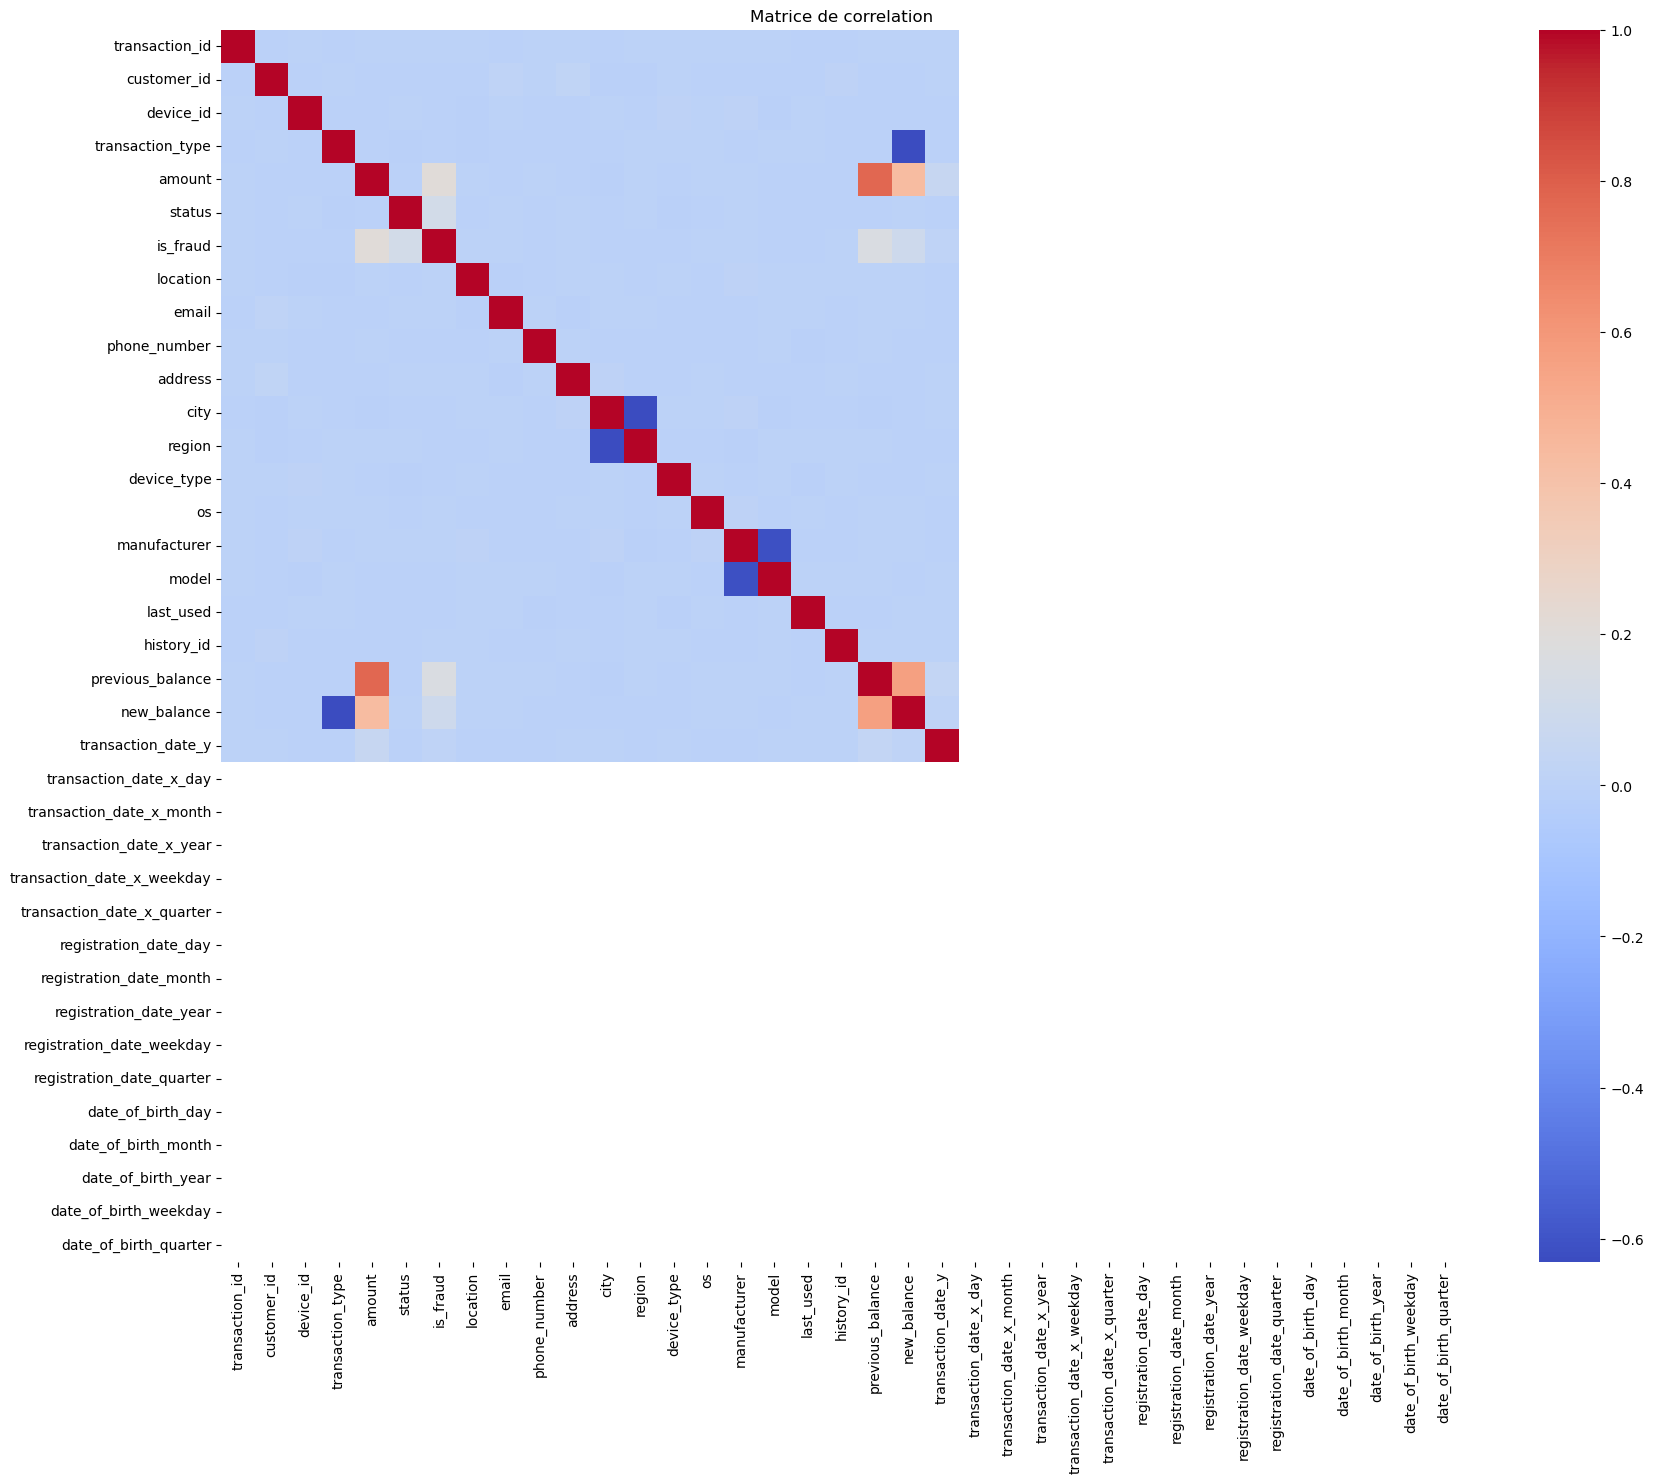

In [66]:
# Analyse de correlation
corr_matrix = df3.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

In [67]:
# Selection des variables les plus correlees avec is_fraud
correlations_with_fraud = corr_matrix['is_fraud'].abs().sort_values(ascending=False)
print("Top 10 variables les plus corrélées avec is_fraud:")
print(correlations_with_fraud.head(10))

Top 10 variables les plus corrélées avec is_fraud:
is_fraud              1.000000
amount                0.209955
previous_balance      0.162420
status                0.115933
new_balance           0.092639
transaction_date_y    0.016235
location              0.004971
city                  0.004961
model                 0.004522
manufacturer          0.004345
Name: is_fraud, dtype: float64


L'information mutuelle est une mesure statistique qui quantifie la dépendance entre deux variables.

ici, Calcule l'information mutuelle entre chaque variable explicative et la variable cible. 

In [68]:
# Information mutuelle
X = df3.drop(columns=['is_fraud']) #Contient les variables explicatives (indépendantes)
y = df3['is_fraud'] #Contient la variable cible (dépendante)
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("\nTop 10 variables selon l'information mutuelle:")
print(mi_scores.head(10))


Top 10 variables selon l'information mutuelle:
amount                    0.031331
last_used                 0.016468
device_id                 0.015518
previous_balance          0.013814
status                    0.011266
new_balance               0.008821
model                     0.007082
date_of_birth_month       0.004186
registration_date_year    0.004083
location                  0.003387
Name: MI Scores, dtype: float64


In [69]:
# Sélection finale des variables importantes
important_features = list(set(list(correlations_with_fraud.head(10).index) + list(mi_scores.head(10).index)))
important_features = [f for f in important_features if f != 'is_fraud']
print("\nVariables importantes sélectionnées:")
print(important_features)


Variables importantes sélectionnées:
['date_of_birth_month', 'status', 'manufacturer', 'new_balance', 'registration_date_year', 'previous_balance', 'location', 'device_id', 'last_used', 'amount', 'model', 'city', 'transaction_date_y']


In [70]:
# Creation du dataset final
X_final = df3[important_features]
y_final = df3['is_fraud']

In [71]:
# Entrainement du modele avec Isolation Forest
model = IsolationForest(contamination=0.5, random_state=42)
y_pred = model.fit_predict(X_final)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [72]:
y_pred

array([-1,  1,  1, ..., -1,  1,  1])

Isolation Forest: calcule un score d'anomalie pour chaque observation du dataset. Ce score donne une mesure de la normalité de chaque observation en fonction de l'ensemble des données.

In [73]:
# Ajout des predictions du DataFrame
df3['anomaly'] = y_pred

In [74]:
# Affichage des resultats
print("\nNombre d'anomalies detectees:", sum(y_pred == -1))
print("\nExemples d'anomalies detectees:")
print(df3[df3['anomaly'] == -1].head()) # sélectionne uniquement les lignes du DataFrame df où la condition est True (c'est-à-dire les lignes correspondant aux anomalies).


Nombre d'anomalies detectees: 50000

Exemples d'anomalies detectees:
   transaction_id  customer_id  device_id  transaction_type        amount  \
0           45184         8116      60985                 0  9.385805e+06   
5           27378         1763       8486                 0  8.835403e+06   
6           52653         6622        643                 1  7.034970e+06   
7           85227         4213      49353                 1  4.644982e+06   
8           42197          874      61373                 1  1.129839e+07   

   status  is_fraud  location  email  phone_number  ...  \
0       0         1        31   5665          1606  ...   
5       0         1        16   2906          6715  ...   
6       0         1        98   5180          8974  ...   
7       0         0        31   6979          2674  ...   
8       0         1        39   4129          7097  ...   

   registration_date_month  registration_date_year  registration_date_weekday  \
0                        1     

In [75]:
# evaluons la precision du modele
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convertir les prédictions de l'Isolation Forest (-1 pour anomalie, 1 pour normal) 
# en format binaire (1 pour anomalie, 0 pour normal)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Calculer et afficher les métriques de classification
print(classification_report(y_final, y_pred_binary))

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_final, y_pred_binary)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       0.49      0.56      0.52     43293
           1       0.62      0.55      0.58     56707

    accuracy                           0.56    100000
   macro avg       0.56      0.56      0.55    100000
weighted avg       0.56      0.56      0.56    100000

AUC-ROC: 0.5562012595900026


Un AUC-ROC de 0.5562 indique que votre modèle de classification a des performances très faibles. Il ne parvient pas à discriminer efficacement les classes positives des négatives.

In [76]:
# Afficher la matrice de confusion
print("Matrice de confusion:")
print(confusion_matrix(y_final, y_pred_binary))

Matrice de confusion:
[[24406 18887]
 [25594 31113]]


In [77]:
# Affichage des résultats
print("\nNombre d'anomalies détectées:", sum(y_pred == -1))
print("\nExemples d'anomalies détectées:")
print(df3[df3['anomaly'] == -1].head())


Nombre d'anomalies détectées: 50000

Exemples d'anomalies détectées:
   transaction_id  customer_id  device_id  transaction_type        amount  \
0           45184         8116      60985                 0  9.385805e+06   
5           27378         1763       8486                 0  8.835403e+06   
6           52653         6622        643                 1  7.034970e+06   
7           85227         4213      49353                 1  4.644982e+06   
8           42197          874      61373                 1  1.129839e+07   

   status  is_fraud  location  email  phone_number  ...  \
0       0         1        31   5665          1606  ...   
5       0         1        16   2906          6715  ...   
6       0         1        98   5180          8974  ...   
7       0         0        31   6979          2674  ...   
8       0         1        39   4129          7097  ...   

   registration_date_month  registration_date_year  registration_date_weekday  \
0                        1     